**Table of contents**<a id='toc0_'></a>    
- [Initial Tests](#toc1_)    
- [Using minimize from scipy.optimize](#toc2_)    
- [Using PyTorch](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Initial Tests](#toc0_)

In [1]:
#from optic.models.devices import mzm, pm
#from optic.utils import parameters
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

π = np.pi

SpS = 64            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

t = np.arange(0, SpS*500)*Ta

Vπ = 2
P = 1
n_peaks = 11


In [2]:
def pm(Ai, u, Vπ):
    #return Ai * np.exp(1j* (u / Vπ) * np.pi)
    #open the complex equation in exp(1j*x) = cos(x) + 1j*sin(x) 
    return Ai*np.cos(u/Vπ*np.pi) + 1j*Ai*np.sin(u/Vπ*np.pi) #it is faster

def mzm(Ai, u, Vπ, Vb):
    return Ai * np.cos(0.5 / Vπ * (u + Vb) * np.pi)

In [3]:
def ddmzm(Ai, u1, u2, Vb1, Vb2, Vπ):
    return 0.5 * Ai * (pm(1, u1 + Vb1, Vπ) + pm(1, u2 + Vb2, Vπ))

In [4]:
def fb_generator(V1, V2, Phase1, Phase2, Vb1, Vb2):
    '''
    par1 = parameters()
    par1.Vpi = Vπ
    par1.Vb = Vb1

    par2 = parameters()
    par2.Vpi = Vπ
    par2.Vb = Vb2

    sigTxo_ = P
    sigTxo_ = mzm(sigTxo_, V1 * np.cos(2 * π * Rs * t + Phase1), par1)
    sigTxo_ =  pm(sigTxo_, V3 * np.cos(2 * π * Rs * t + Phase3), Vπ)
    sigTxo_ = mzm(sigTxo_, V2 * np.cos(2 * π * Rs * t + Phase2), par2)
    '''

    u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
    u2 = V2 * np.cos(2 * π * Rs * t + Phase2)
    fb = ddmzm(P, u1, u2, Vb1, Vb2, Vπ)

    return fb

In [5]:
t = np.arange(0, SpS*1000)*Ta
V1 = 1
V2 = 1
Phase1 = 0
Phase2 = 0
u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
u2 = V2 * np.cos(2 * π * Rs * t + Phase2)

%timeit pm(P, u1, Vπ)
%timeit mzm(P, u1, Vπ, 0)
%timeit ddmzm(P, u1, u2, 0, 0, Vπ)

print('')
t = np.arange(0, SpS*500)*Ta
V1 = 1
V2 = 1
Phase1 = 0
Phase2 = 0
u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
u2 = V2 * np.cos(2 * π * Rs * t + Phase2)

%timeit pm(P, u1, Vπ)
%timeit mzm(P, u1, Vπ, 0)
%timeit ddmzm(P, u1, u2, 0, 0, Vπ)

1.87 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
352 µs ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.09 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

597 µs ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
173 µs ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.32 ms ± 51.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
def get_psd_ByFFT(signal, Fa, NFFT = 16*1024):
    
    fft_result = np.fft.fftshift(np.fft.fft(signal, NFFT))
    power_spectrum = np.abs(fft_result)**2
    psd = power_spectrum / (NFFT*Fa)
    freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, 1 / Fa))

    #min_psd = np.min(psd[psd != 0])
    min_psd = 10e-100
    psd[psd == 0] = min_psd
    
    return psd, freqs

In [7]:
signal = fb_generator(1, 1, 0, 0, 0, 0)
%timeit get_psd_ByFFT(signal, Fa, 16*1024)
%timeit get_psd_ByFFT(signal, Fa, 20*1024)

444 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
552 µs ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
def get_indx_peaks(log_Pxx, n_peaks):
    indx = find_peaks(log_Pxx, height=(-330, 0))[0]
    discard = (indx.size - n_peaks)
    indx = indx[int(np.floor(discard/2)): -int(np.ceil(discard/2))]
    return indx

In [8]:
#from numpy.fft import fftshift
def plot_fb(sigTxo_, n_peaks):
    # plot frequency combs
    
    plt.figure(figsize=(10,5));
    
    Pxx, freqs = get_psd_ByFFT(sigTxo_, Fa)
    log_Pxx = 10*np.log10(Pxx)
    
    plt.plot(freqs, log_Pxx, "-",label = 'Espectro do sinal óptico - FFT')
    
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right')
    plt.xticks(np.arange(-25*Rs,25*Rs+1,5*Rs), np.arange(-25, 25+1, 5))
    #plt.xlim(-20*Rs,20*Rs);
    plt.xlabel("Frequência (GHz) - Normalized to symbol rate");
    #plt.ylim(-150,-80);
    plt.grid()
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx]) 
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    

Média: -158.18 dB
Desvio Padrão: 51.08 dB
Variância: 2609.33
Distância máximo-mínimo: 158.08 dB


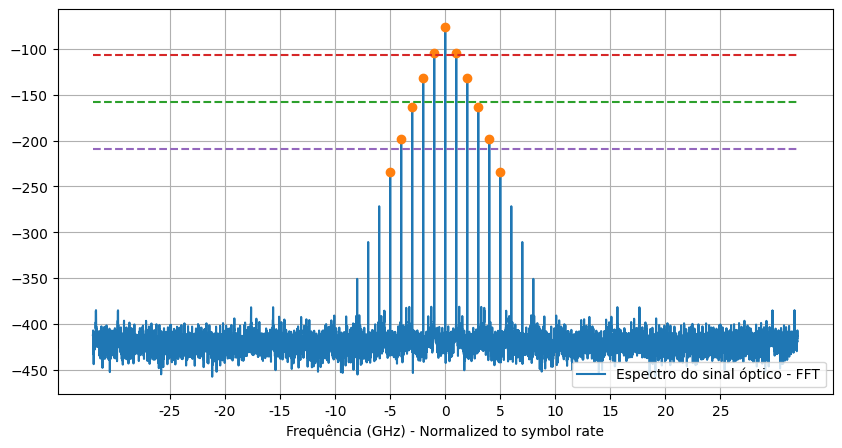

In [9]:
fb = fb_generator(1,2,1,1,1,1)
fb = fb_generator(0.1,0,0,0,0,0)

plot_fb(fb, n_peaks)

In [10]:
import ipywidgets as widgets

def plot_frequencyComb(V1, V2,Phase1, Phase2, Vb1, Vb2):

    plt.figure(figsize=(10,5));

    fb = fb_generator(V1, V2,Phase1, Phase2, Vb1, Vb2)
    Pxx, freqs = get_psd_ByFFT(fb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)

    plt.plot(freqs, log_Pxx, label = 'Espectro do sinal óptico')
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right')
    plt.xlabel("Frequência (GHz) - Normalized to symbol rate");

    plt.xticks(np.arange(-20*Rs,20*Rs+1,5*Rs), np.arange(-20, 20+1, 5))
    plt.xlim(-20*Rs,20*Rs)
    #plt.ylim(-150,-80)
    plt.grid()


V_min = 0
V_max = 5.0
Phase_min = 0.0
Phase_max = 2.0*π
Vb_min = 0.0
Vb_max = 4.0*Vπ

V1 = widgets.FloatSlider(value=1, min=V_min, max=V_max,step = 0.001, description = 'V1')
V2 = widgets.FloatSlider(value=1, min=V_min, max=V_max,step = 0.001, description = 'V2')
Phase1 = widgets.FloatSlider(value=0, min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=0, min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase2')
Vb1 = widgets.FloatSlider(value=0, min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb1')
Vb2 = widgets.FloatSlider(value=0, min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb2')


ui1 = widgets.HBox([V1, V2])
ui2 = widgets.HBox([Phase1, Phase2])
ui3 = widgets.HBox([Vb1, Vb2])

out1 = widgets.interactive_output(plot_frequencyComb, {'V1': V1, 'V2': V2,'Phase1':Phase1, 'Phase2':Phase2, 'Vb1': Vb1, 'Vb2': Vb2})
display(ui1, ui2,ui3,out1)

Output()

In [11]:
def plot_sig_and_fb(sig):

    fig, ax = plt.subplots(2,2,figsize = (20,10));
    ax[0,0].plot(t[:SpS*4]*1e9, sig[:SpS*4].real);
    ax[0,1].plot(t[:SpS*4]*1e9, sig[:SpS*4].imag);
    ax[1,0].plot(t[:SpS*4]*1e9, abs(sig[:SpS*4])**2);
    Pxx, freqs = get_psd_ByFFT(sig, Fa)
    log_Pxx = 10*np.log10(Pxx)
    ax[1,1].plot(freqs, log_Pxx, label = 'Espectro do sinal óptico')
    
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    ax[1,1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1,1].legend(loc='lower right');
    #ax[1,1].xlim(-16*Rs,16*Rs);
    #ax[1,1].ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    
    ax[0,0].grid()
    ax[0,1].grid()
    ax[1,0].grid()
    #ax[1,1].grid()


Média: -92.60 dB
Desvio Padrão: 4.07 dB
Variância: 16.57
Distância máximo-mínimo: 13.98 dB


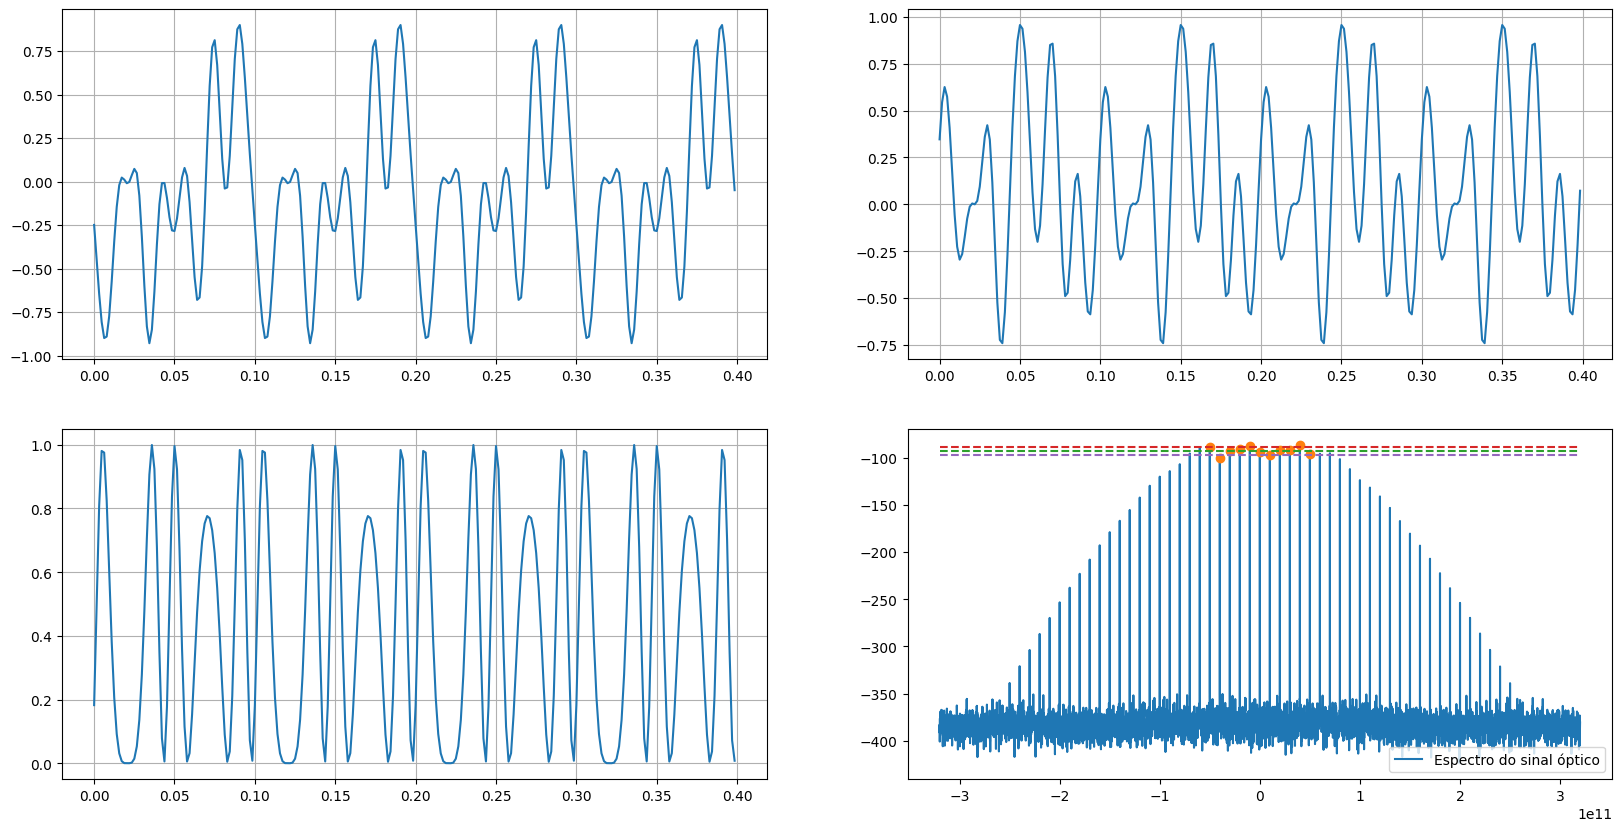

In [12]:
initial_guess = [1,2,1,1,1,1]
initial_guess = [3.4197, 4.0299, 3.9854, 2.6301, 6.9508, 5.6303]
sig = fb_generator(*initial_guess)
plot_sig_and_fb(sig)

# <a id='toc2_'></a>[Using minimize from scipy.optimize](#toc0_)

In [36]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    fb = fb_generator(*params)

    Pxx, _ = get_psd_ByFFT(fb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    var = np.var(log_Pxx[indx])
    target_var = 0
    
    # Objetivo: planificar os picos
    return (var - target_var)**2
 

In [49]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [3, 2, 2, 2, 3, 2]

V_min = 0
V_max = 5
Phase_min = 0
Phase_max = 2*π
Phase_max = π/2
Vb_min = 0
Vb_max = 4*Vπ
Vb_max = 2*Vπ

bounds = [(V_min,V_max),(V_min,V_max),(Phase_min, Phase_max),(Phase_min, Phase_max),(Vb_min,Vb_max),(Vb_min,Vb_max)]

# Realizar a otimização
method = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr", "COBYLA"]
result = minimize(objective_function, initial_guess, method=method[6],bounds = bounds)
optimized_params = result.x

V1, Phase1,  Vb1, V2, Phase2, Vb2 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.2f} V")
print(f"V2: {V2:.2f} V")
print(f"Phase1: {Phase1:.2f} rad")
print(f"Phase2: {Phase2:.2f} rad")
print(f"Vb1: {Vb1:.2f} V")
print(f"Vb2: {Vb2:.2f} V")

Configurações otimizadas:
V1: 4.06 V
V2: 1.57 V
Phase1: 3.43 rad
Phase2: 2.98 rad
Vb1: 1.57 V
Vb2: 1.48 V


[4.06272973 3.43462156 1.56805446 1.56803667 2.97554328 1.47611193]
Média: -93.43 dB
Desvio Padrão: 0.49 dB
Variância: 0.24
Distância máximo-mínimo: 1.22 dB


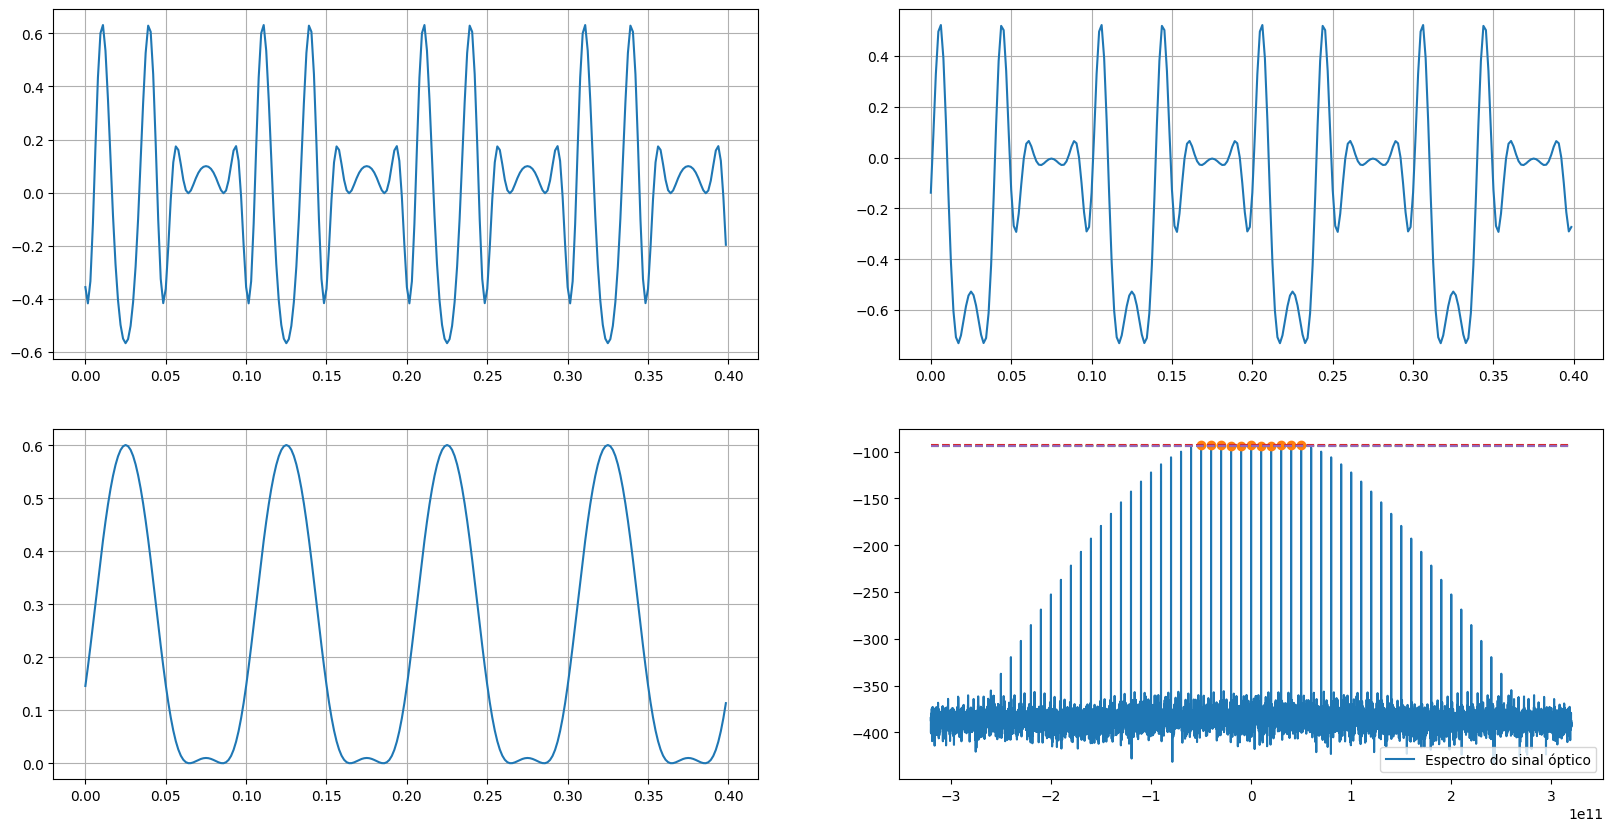

In [52]:
fb = fb_generator(*optimized_params)
print(optimized_params)
plot_sig_and_fb(fb)

# <a id='toc3_'></a>[Using PyTorch](#toc0_)

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand
#import gc

In [8]:
def fb_peaks(V1, V2, Phase1, Phase2, Vb1, Vb2):
    
    fb = fb_generator(V1, V2, Phase1, Phase2, Vb1, Vb2)
    Pxx, _ = get_psd_ByFFT(fb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)

    return log_Pxx[indx]

In [9]:
# Define your neural network architecture
class FrequencyCombNet(nn.Module):
    def __init__(self):
        super(FrequencyCombNet, self).__init__()
        self.layers = nn.Sequential(
                    nn.Linear(6, 128),
                    nn.ReLU(),
                    nn.Linear(128, 256),
                    nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, 11))

    def forward(self, x):
        return self.layers(x[:, :11])

In [10]:

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, myfunction, nsamples, bounds):
        self.nsamples = nsamples
        self.bounds = bounds
        self.samples = [[urand.Uniform(low, high).sample().item() for low, high in bounds] for _ in range(nsamples)]
        #self.data = [(torch.tensor(sample, dtype=torch.float32), self.max_abs_scaling(torch.tensor(myfunction(*sample), dtype=torch.float32))) for sample in self.samples] # perhaps list comprehension is faster than for loop
        
        self.data = []
        for sample in self.samples:
            input_tensor = torch.tensor(sample, dtype=torch.float32)
            output_tensor = torch.tensor(myfunction(*sample), dtype=torch.float32)
            output_tensor = self.max_abs_scaling(output_tensor)
            self.data.append((input_tensor, output_tensor))
        

    def __len__(self):
        return len(self.data)
    
    def data_size(self):
        total_size_in_bytes = sum(data.nelement() * data.element_size() + target.nelement() * target.element_size() for data, target in self.data)
        total_size_in_kilobytes = total_size_in_bytes / 1024
        return total_size_in_kilobytes
    
    def max_abs_scaling(tensor):
        return tensor / torch.max(torch.abs(tensor)) + 1
    
    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
V_min = 0.1
V_max = 5
Phase_min = 0
Phase_max = 2*π
Vb_min = 0
Vb_max = 4*Vπ

bounds = [(V_min,V_max),(V_min,V_max),(Phase_min, Phase_max),(Phase_min, Phase_max), (Vb_min,Vb_max), (Vb_min,Vb_max)]

train_nsamples = 100000
test_nsamples  = 10000
val_nspamples  = 10000
n_peaks = 11

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


In [12]:
#load datasets if they exist, create them otherwise
train_filename = "saved_datasets/train_dataset.pt"
test_filename = "saved_datasets/test_dataset.pt"
val_filename = "saved_datasets/val_dataset.pt"
if os.path.exists(train_filename) and os.path.exists(test_filename) and os.path.exists(val_filename):
    print("Loading datasets...")
    train_dataset = torch.load(train_filename)
    test_dataset = torch.load(test_filename)
    val_dataset = torch.load(val_filename)
    print("Datasets loaded!")
else:
    print("Creating datasets...")
    train_dataset = FrequencyCombDataset(fb_peaks, train_nsamples, bounds)
    test_dataset = FrequencyCombDataset(fb_peaks, test_nsamples, bounds)
    val_dataset = FrequencyCombDataset(fb_peaks, val_nspamples, bounds)
    print("Datasets created!")

    torch.save(train_dataset, train_filename)
    torch.save(test_dataset, test_filename)
    torch.save(val_dataset, val_filename)
    print("Datasets saved!")

Loading datasets...
Datasets loaded!


In [13]:
print(f"Train Dataset Size: {train_dataset.data_size():.2f} kB")
print(f"Test Dataset Size: {test_dataset.data_size():.2f} kB")
print(f"Validation Dataset Size: {val_dataset.data_size():.2f} kB")

Train Dataset Size: 6640.62 kB
Test Dataset Size: 664.06 kB
Validation Dataset Size: 664.06 kB


In [14]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [15]:
# Initialize the model
model = FrequencyCombNet().to(device)
model_name = "model_large_dataset_test5"

# load model
if os.path.exists('saved_models/'+ model_name +'.pth'):
    print("Loading model...")
    model.load_state_dict(torch.load('saved_models/'+ model_name +'.pth'))
    model.eval()
    print("Model loaded!")
else:
    print("No model to load!")

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr - learning rate

Loading model...
Model loaded!


In [28]:
def plot_training_progress(train_losses, val_losses, mode = "together"):
    
    if mode == "together":
        plt.figure(figsize=(15,5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss', color='r')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.legend()
        #plt.xlim([len(train_losses)-1000, len(train_losses)])

    else:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(train_losses, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        ax2.plot(val_losses, label='Validation Loss', color='r')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [17]:
# Training loop

## losses

train_losses_file = model_name + '_train_losses.npy'
val_losses_file = model_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(train_losses_file) and os.path.exists(val_losses_file):
    train_losses = list(np.load(train_losses_file))
    val_losses = list(np.load(val_losses_file))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Creating new losses files...")

Losses files loaded!


Epoch: 2000/14000.. Training loss: 0.000446.. Validation Loss: 0.000693


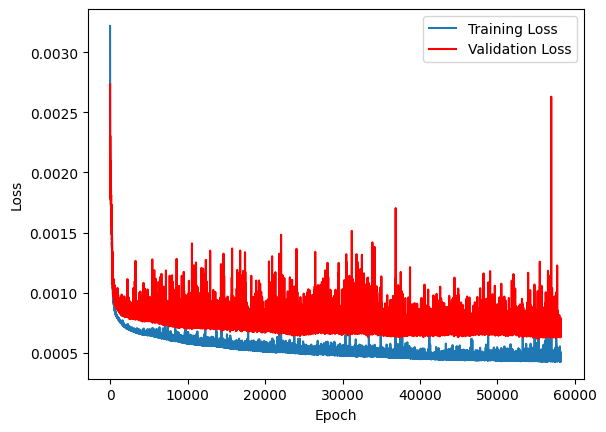

Epoch: 4000/14000.. Training loss: 0.000466.. Validation Loss: 0.000687


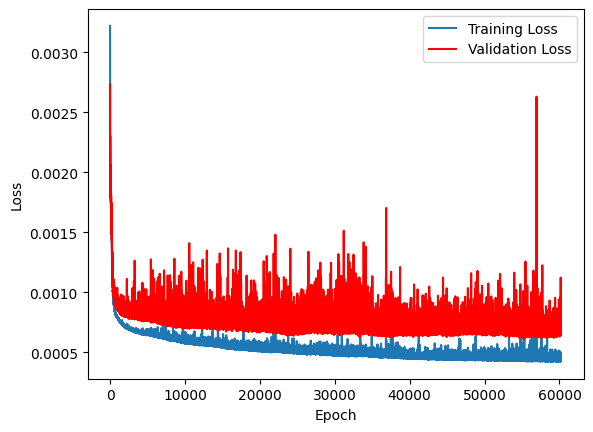

Epoch: 6000/14000.. Training loss: 0.000462.. Validation Loss: 0.000805


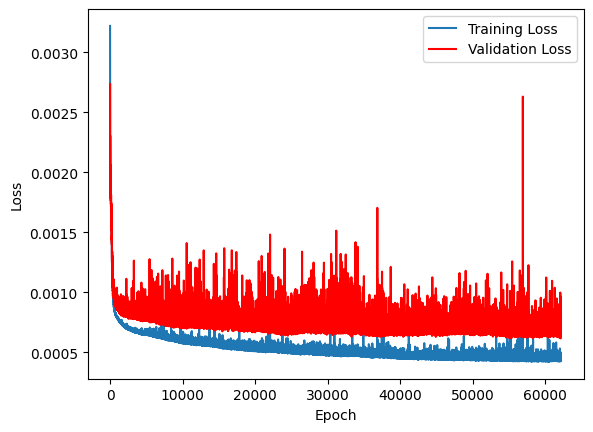

Epoch: 8000/14000.. Training loss: 0.000428.. Validation Loss: 0.000659


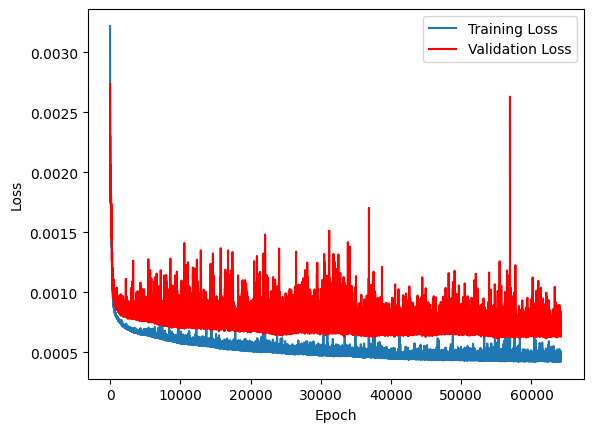

Epoch: 10000/14000.. Training loss: 0.000447.. Validation Loss: 0.000675


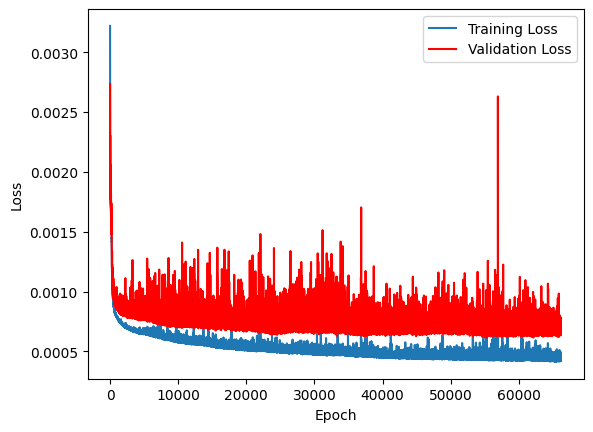

Epoch: 12000/14000.. Training loss: 0.000416.. Validation Loss: 0.000663


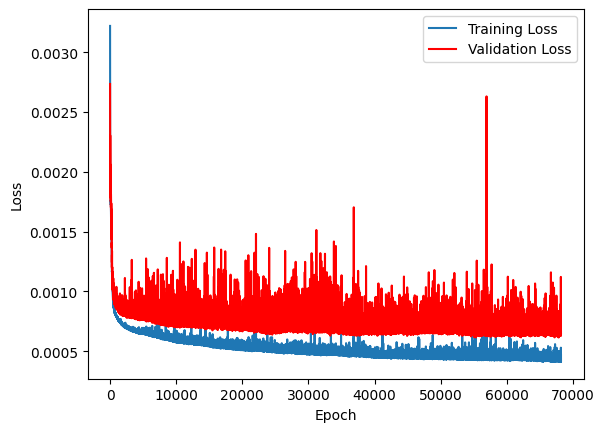

Epoch: 14000/14000.. Training loss: 0.000428.. Validation Loss: 0.000707


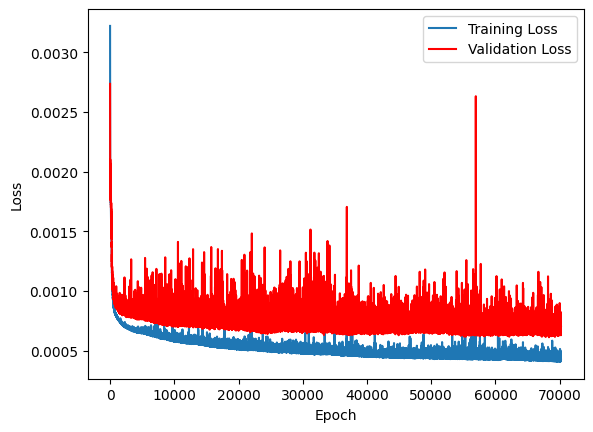

In [57]:
num_epochs = 14000
for epoch in range(1, num_epochs + 1):

    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs) # Calculate outputs (forward pass)
        loss = criterion(outputs, targets) # Calculate loss

        # Backward pass
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights
    
        # Delete tensors and free up GPU memory
        #del inputs, targets, outputs # Delete tensors
        #torch.cuda.empty_cache() # Clear cache

        running_loss += loss.item() * inputs.size(0) # Accumulate loss for each batch
    avg_train_loss = running_loss / len(train_loader.dataset) # Calculate average loss over an epoch
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    if(epoch%2000 == 0):
        # Print training progress
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(train_losses, val_losses, mode = "together")


In [63]:
# Save model
torch.save(model.state_dict(), 'saved_models/'+ model_name +'.pth')

# Save training and validation losses
np.save(train_losses_file, np.array(train_losses))
np.save(val_losses_file, np.array(val_losses))


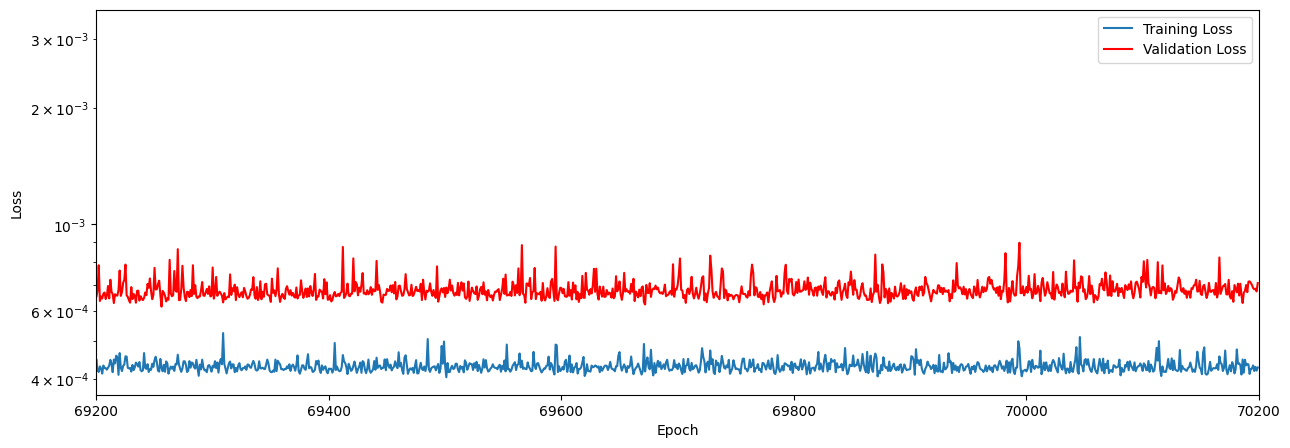

In [29]:
plot_training_progress(train_losses, val_losses, mode = "together")

In [65]:
# Test phase
model.eval() # Set model to evaluation mode
test_losses = []
with torch.no_grad(): # Disable gradient calculation
    running_test_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        running_test_loss += test_loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss) # Append average test loss
test_losses

[0.0006944326770724729]

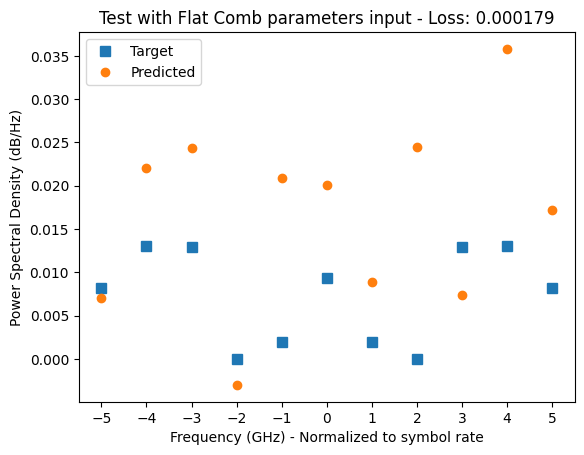

In [58]:
# Test with flat comb
model.eval() # Set model to evaluation mode
with torch.no_grad():
    params = [4.06272973, 3.43462156, 1.56805446, 1.56803667, 2.97554328, 1.47611193]

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(fb_peaks(*params), dtype=torch.float32).unsqueeze(0).to(device)
    target = FrequencyCombDataset.max_abs_scaling(target_non_norm)
    output = model(input)

    plt.figure()
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),output.squeeze().cpu().numpy(),"o", label='Predicted')
    plt.xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    plt.xlabel("Frequency (GHz) - Normalized to symbol rate")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.legend()
    plt.title(f'Test with Flat Comb parameters input - Loss: {criterion(output, target):.6f}')

inputs:  tensor([2.3754, 0.7437, 3.1722, 6.1587, 3.0509, 2.2044], device='cuda:0')
loss:  4.6877805289113894e-05


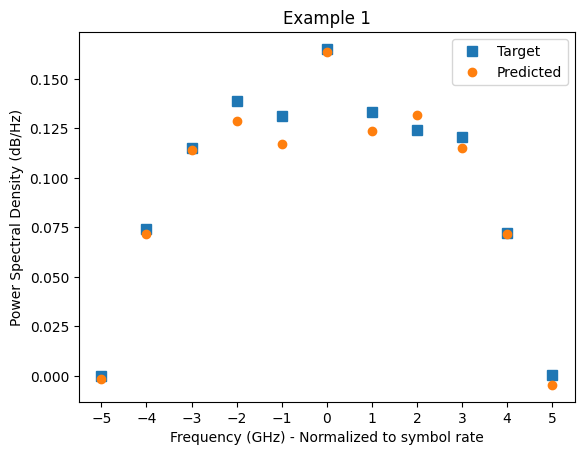

inputs:  tensor([0.5213, 1.4985, 2.6933, 4.6822, 2.9010, 2.2673], device='cuda:0')
loss:  0.00012265190889593214


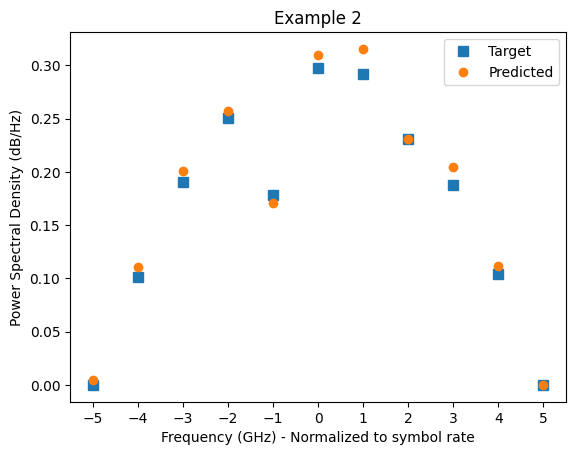

inputs:  tensor([3.9957, 4.9112, 5.0106, 5.0630, 5.5424, 1.1777], device='cuda:0')
loss:  0.00017401727382093668


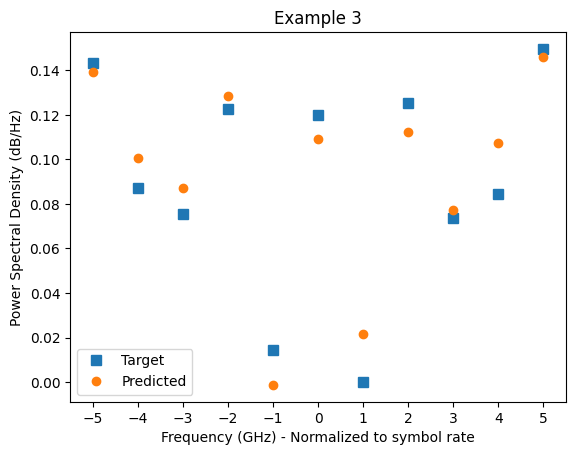

inputs:  tensor([3.2720, 1.6018, 5.3763, 4.1641, 3.0117, 0.1767], device='cuda:0')
loss:  0.00023912673350423574


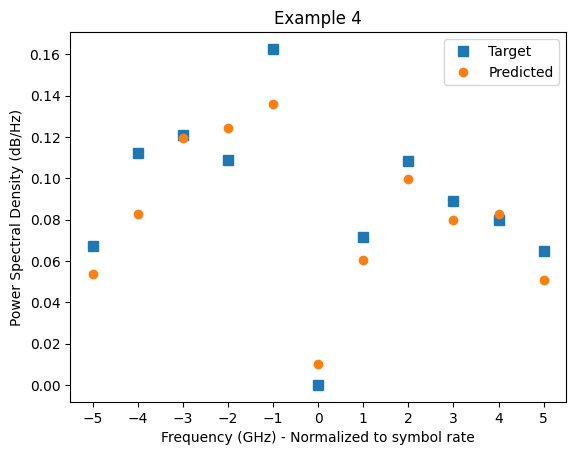

inputs:  tensor([3.4197, 4.0299, 3.9854, 2.6301, 6.9508, 5.6303], device='cuda:0')
loss:  0.0005026470171287656


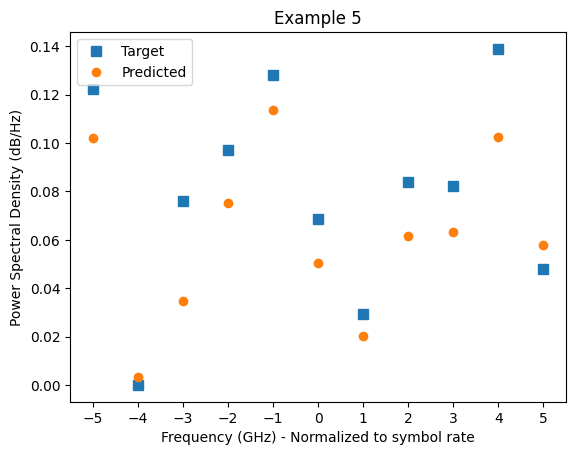

inputs:  tensor([3.6439, 4.9613, 6.1860, 1.4510, 7.0659, 4.8194], device='cuda:0')
loss:  0.00011280623584752902


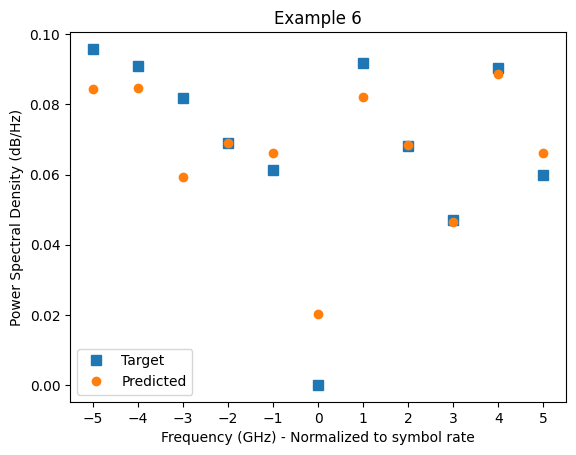

inputs:  tensor([4.2862, 3.3925, 2.7050, 1.1254, 1.0910, 2.2245], device='cuda:0')
loss:  0.00011667505896184593


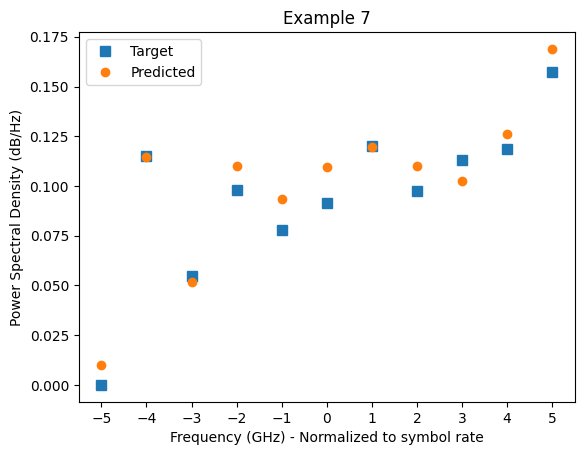

inputs:  tensor([2.5230, 4.3487, 3.9618, 5.2627, 5.6661, 0.7366], device='cuda:0')
loss:  0.0003737129154615104


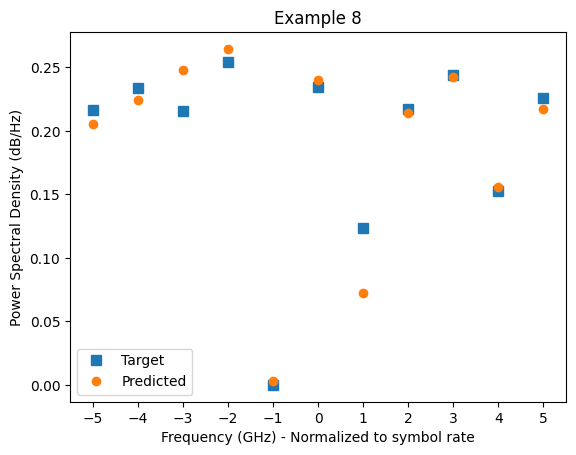

inputs:  tensor([1.5570, 2.7964, 0.7066, 0.0436, 7.8766, 2.5125], device='cuda:0')
loss:  0.00010593200568109751


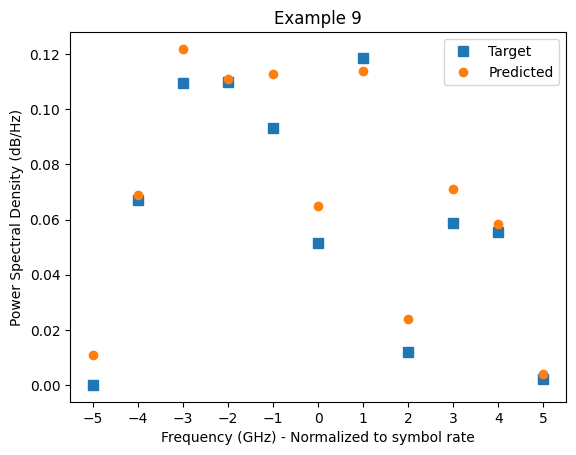

inputs:  tensor([0.8024, 3.6267, 0.9429, 1.3770, 5.8652, 4.6162], device='cuda:0')
loss:  9.494522964814678e-05


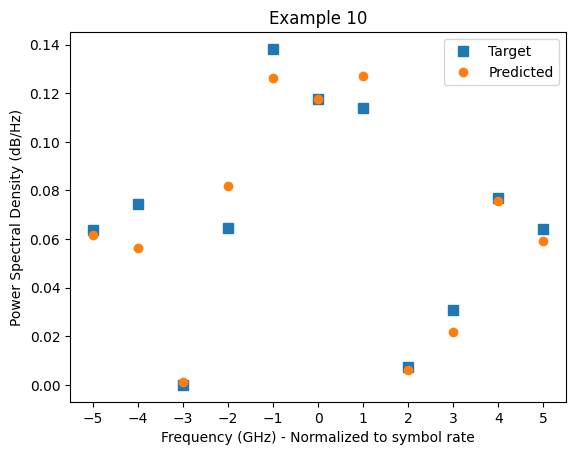

In [68]:
for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples
    plt.figure()
    print("inputs: ", inputs[i])
    print("loss: ", criterion(outputs[i], targets[i]).item())
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs[i].cpu().numpy(),"o", label='Predicted')
    plt.xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    plt.xlabel("Frequency (GHz) - Normalized to symbol rate")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.legend()
    plt.title(f'Example {i+1}')
    plt.show()